In [ ]:
!pip install torch
!pip install torchvision

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable

In [2]:
#@title AdLaLa optimizer
import math
import torch.nn.functional as F
from torch.optim.optimizer import Optimizer, required

class AdLaLa(Optimizer):
    def __init__(self,params,lr=0.25,eps=0.05,sigA = 5e-4,T1=1e-6,cgamma=0,dgamma=0):
        defaults = dict(lr=lr,eps=eps,sigA=sigA,T1=T1,cgamma=cgamma,dgamma=dgamma)
        super().__init__(params,defaults)

    def __setstate__(self,state):
        super().__setstate__(state)

    @torch.no_grad()
    def stepMom(self):
        for group in self.param_groups:
            num = 0
            lr = group['lr'] # Stepsize lr

            for p in group['params']: # Runs through the network parameters

                param_state = self.state[p]

                d_p = p.grad  # Compute gradients (derivative of the loss wrt the parameters)

                # Initialize the momenta to be zero
                Mom = param_state['momentum_buffer'] = 0*torch.clone(d_p).detach()

                # Take a half B step: update momenta Mom = Mom - (lr/2)*Grad, where grad = d_p, lr = stepsize
                Mom.add_(-lr*d_p/2)

                if num < 2:  # If first layer, then we want to use the Adaptive Langevin optimizer
                    # Initialize xi variable
                    if num == 0: # For the weights
                        xi = param_state['xis'] = 0.1*torch.ones_like(d_p[0][0]).detach()
                    else: # For the biases
                        xi = param_state['xis'] = 0.1*torch.ones_like(d_p[0]).detach()

                num += 1


    @torch.no_grad()
    def stepAOA(self):

        for group in self.param_groups:
            num = 0

            lr = group['lr'] # stepsize
            cgamma = group['cgamma']
            dgamma = group['dgamma']
            eps = group['eps']
            sigA  = group['sigA']
            T1 = group['T1']

            for p in group['params']: # Runs through the networks parameters
                param_state = self.state[p]

                if num < 2: # If first layer, then we want to use the Adaptive Langevin optimizer
                # For Adaptive langevin we use the ACDEDCAB optimizer
                # The A and B steps are the same as for the Langevin BAOAB scheme,
                # for more details see p.10 in our arXiv 1908.11843 paper

                    # Recall the current state of the momenta and xi variables
                    Mom = param_state['momentum_buffer']
                    xi = param_state['xis']

                    # A-step:  update parameters p = p + (lr/2)*Mom, with stepsize lr
                    p.add_(Mom*lr/2)

                    # C-step: update momenta Mom = exp(-xi*lr/2)*Mom
                    C = torch.exp(-xi*lr/2)
                    Mom.mul_(C)

                    # D-step: update momenta Mom = Mom + sig*sqrt(lr/2)*R,
                    # where R is a standard normal random vector with iid components
                    shapep = p.size()
                    D = sigA*np.sqrt(lr/2)
                    Mom.add_(D*torch.cuda.FloatTensor(*shapep).normal_())

                    # E-step:update xi = xi + eps*lr*(Mom^T Mom - N*T1), where N = # of degrees of freedom
                    if num == 0: # For the weights
                        E = torch.dot(Mom.reshape(shapep[0]*shapep[1],1).squeeze(),Mom.reshape(shapep[0]*shapep[1],1).squeeze())-shapep[0]*shapep[1]*T1
                    else: # For the biases
                        E = torch.dot(Mom.reshape(shapep[0],1).squeeze(),Mom.reshape(shapep[0],1).squeeze())-shapep[0]*T1

                    F = eps*lr
                    xi.add_(F*E)

                    # D-step: update momenta Mom = Mom + D*R, D = sig*sqrt(lr/2)
                    Mom.add_(D*torch.cuda.FloatTensor(*shapep).normal_())

                    # C-step: update momenta Mom = exp(-xi*lr/2)*Mom
                    C = torch.exp(-xi*lr/2)
                    Mom.mul_(C)

                    # A-step: update parameters p = p + (lr/2)*Mom
                    p.add_(Mom*lr/2)

                else:  # If not first layer, then we want to use the Langevin optimizer
                # For langevin we use the BAOAB optimizer
                # -> in practice we use AOAB, for more details see p.7 in our arXiv 1908.11843 paper

                    Mom = param_state['momentum_buffer'] # Recall the current state of the momenta variables

                    # A-step: update parameters p = p + (lr/2)*Mom, with stepsize lr
                    p.add_(Mom*lr/2)

                    # O-step:  update momenta Mom = cgam*Mom + dgam*R,
                    # where R is a standard normal random vector with iid components and cgam and dgam are defined in main file
                    shapep = p.size()
                    Mom.mul_(cgamma).add_(torch.cuda.FloatTensor(*shapep).normal_(),alpha=dgamma)

                    # A-step:  update parameters p = p + (lr/2)*Mom,
                    p.add_(Mom*lr/2)

                num += 1

    @torch.no_grad()
    def stepB(self):

         for group in self.param_groups:
            lr = group['lr']
            for p in group['params']:

                if p.grad is None:
                    continue

                # Compute gradients (derivative of the loss wrt the parameters)
                d_p = p.grad

                param_state = self.state[p]

                # Recall the current state of the momenta variables
                Mom = param_state['momentum_buffer']

                # B-step: update momenta Mom = Mom - lr*grad, where grad = d_p, lr = stepsize
                Mom.add_(-lr*d_p)


In [3]:
#@title Shared hyperparameters

input_size = 784 # img_size = (28,28) ---> 28*28=784 in total
hidden_size = 500 # number of nodes at hidden layer
num_classes = 10 # number of output classes discrete range [0,9]
num_epochs = 20 # number of times which the entire dataset is passed throughout the model
batch_size = 100 # the size of input data took for one iteration

In [4]:
#@title Downloading MNIST data

train_data = dsets.MNIST(
    root = './data',
    train = True,
    transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ]),
    download = True)

test_data = dsets.MNIST(
    root = './data',
    train = False,
    transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ]),
    download = True)

100%|██████████| 9912422/9912422 [00:00<00:00, 110227772.53it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 68361001.03it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 32245676.17it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 4759062.89it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
#@title Loading the data

train_gen = torch.utils.data.DataLoader(dataset = train_data,
                                        batch_size = batch_size,
                                        shuffle = True)

test_gen = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size,
                                      shuffle = False)

In [ ]:
#@title Define model class

class SingleHiddenLayerPerceptron(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super().__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_size, num_classes)

  def forward(self,x):
    out = self.fc1(x)
    out = self.relu(out)
    out = self.fc2(out)
    return out

In [ ]:
def eval_accuracy(network, test_generator):
    correct = 0
    total = 0
    for images, labels in test_generator:
        images = Variable(images.view(-1,28*28)).cuda()
        labels = labels.cuda()

        output = network(images)
        _, predicted = torch.max(output,1)
        correct += (predicted == labels).sum()
        total += labels.size(0)
    return correct.item() / total

# Adam

In [ ]:
#@title Build the model

net = SingleHiddenLayerPerceptron(input_size, hidden_size, num_classes)
if torch.cuda.is_available():
  net.cuda()

In [ ]:
#@title Define loss-function & optimizer
# default hp for Adam

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters())

In [ ]:
#@title Training the model (Adam)
epoch_train_loss = []
train_loss = []
accuracy_history = [eval_accuracy(net, test_gen)]

for epoch in range(num_epochs):
    acc_loss = 0
    for i, (images,labels) in enumerate(train_gen):
        images = Variable(images.view(-1,28*28)).cuda()
        labels = Variable(labels).cuda()

        optimizer.zero_grad()
        outputs = net(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        this_loss = loss.item()
        train_loss.append(this_loss)
        acc_loss += this_loss
        if (i+1) % 100 == 0:
            print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                    %(epoch+1, num_epochs, i+1, len(train_data)//batch_size, this_loss))
    epoch_loss = acc_loss / (len(train_data)//batch_size)
    epoch_train_loss.append(epoch_loss)
    this_accuracy = eval_accuracy(net, test_gen)
    accuracy_history.append(this_accuracy)
    print(f'Epoch {epoch} loss={epoch_loss:.4f}; accuracy={this_accuracy:.3f}')

Epoch [1/20], Step [100/600], Loss: 0.2354
Epoch [1/20], Step [200/600], Loss: 0.1798
Epoch [1/20], Step [300/600], Loss: 0.2754
Epoch [1/20], Step [400/600], Loss: 0.2753
Epoch [1/20], Step [500/600], Loss: 0.0739
Epoch [1/20], Step [600/600], Loss: 0.0997
Epoch 0 loss=0.2219; accuracy=0.968
Epoch [2/20], Step [100/600], Loss: 0.0516
Epoch [2/20], Step [200/600], Loss: 0.0425
Epoch [2/20], Step [300/600], Loss: 0.0281
Epoch [2/20], Step [400/600], Loss: 0.0797
Epoch [2/20], Step [500/600], Loss: 0.1099
Epoch [2/20], Step [600/600], Loss: 0.0982
Epoch 1 loss=0.0859; accuracy=0.975
Epoch [3/20], Step [100/600], Loss: 0.0682
Epoch [3/20], Step [200/600], Loss: 0.0300
Epoch [3/20], Step [300/600], Loss: 0.0421
Epoch [3/20], Step [400/600], Loss: 0.0278
Epoch [3/20], Step [500/600], Loss: 0.0168
Epoch [3/20], Step [600/600], Loss: 0.0502
Epoch 2 loss=0.0562; accuracy=0.973
Epoch [4/20], Step [100/600], Loss: 0.1031
Epoch [4/20], Step [200/600], Loss: 0.0078
Epoch [4/20], Step [300/600], Lo

In [ ]:
#@title Evaluating the accuracy of the model
print(
    f'The final accuracy is: {eval_accuracy(net, test_gen):%}'
)

The final accuracy is: 98.120000%


# AdLaLa

In [ ]:
#@title Build the model

net = SingleHiddenLayerPerceptron(input_size, hidden_size, num_classes)
if torch.cuda.is_available():
  net.cuda()
  print('cuda on')

cuda on


In [ ]:
# AdLaLa hps
lr = 0.1     # Step size / learning rate
tau1 = 1e-4     # Temperature for AdLa part (this is the first part of the partitioned system)
tau2 = 5e-5    # Temperature for Langevin (2nd part)
gamma = 0.15    # Friction parameter for Langevin part
sigma = 0.05    # Driving noise amplitude for Adaptive Langevin
eps = 0.05     # Coupling coefficient for Adaptive Langevin
cgamma = np.exp(-lr*gamma)
dgamma = np.sqrt(1-np.exp(-2*lr*gamma))*np.sqrt(tau2)

loss_function = nn.CrossEntropyLoss()
optimizer = AdLaLa(net.parameters(), lr=lr, eps=eps, sigA=sigma, T1=tau1, cgamma=cgamma, dgamma=dgamma)

In [ ]:
#@title Training the model (AdLaLa)


epoch_train_loss_adlala = []
train_loss_adlala = []
accuracy_history_adlala = [eval_accuracy(net, test_gen)]

for epoch in range(num_epochs):
    acc_loss = 0
    for i, (images,labels) in enumerate(train_gen):
        images = Variable(images.view(-1,28*28)).cuda()
        labels = Variable(labels).cuda()
        outputs = net(images)

        if i == 0 and epoch == 0:
            # Do a B_(h/2) step (p := p - 0.5*h*dL) only at the very first step - after this will be incorporated into a B_h step at the end of each iteration)
            # To do the B_(h/2) step we need to compute dL
            output = net(images)  # The neural network's predicted labels for the provided training data
            loss = loss_function(output, labels) # Compute the binary cross entropy loss between the predicted labels (output) and the true labels (y)

            optimizer.zero_grad()
            loss.backward(retain_graph=True) # retain_graph = True allows us to do .backward again within the same epoch
            optimizer.stepMom()

        optimizer.stepAOA()
        output = net(images)             # The neural network's predicted labels for the provided training data
        loss = loss_function(output, labels) # Compute the difference between the predicted labels (output) and the true labels (y) using the defined loss function
        optimizer.zero_grad()
        loss.backward()
        optimizer.stepB()

        this_loss = loss.item()
        train_loss_adlala.append(this_loss)
        acc_loss += this_loss
        if (i+1) % 100 == 0:
            print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                    %(epoch+1, num_epochs, i+1, len(train_data)//batch_size, this_loss))
    epoch_loss = acc_loss / (len(train_data)//batch_size)
    epoch_train_loss_adlala.append(epoch_loss)
    this_accuracy = eval_accuracy(net, test_gen)
    accuracy_history_adlala.append(this_accuracy)
    print(f'Epoch {epoch+1} loss={epoch_loss:.4f}; accuracy={this_accuracy:.3f}')

Epoch [1/20], Step [100/600], Loss: 0.5208
Epoch [1/20], Step [200/600], Loss: 0.3943
Epoch [1/20], Step [300/600], Loss: 0.3104
Epoch [1/20], Step [400/600], Loss: 0.3528
Epoch [1/20], Step [500/600], Loss: 0.2017
Epoch [1/20], Step [600/600], Loss: 0.2174
Epoch 1 loss=0.3596; accuracy=0.932
Epoch [2/20], Step [100/600], Loss: 0.2589
Epoch [2/20], Step [200/600], Loss: 0.1265
Epoch [2/20], Step [300/600], Loss: 0.1192
Epoch [2/20], Step [400/600], Loss: 0.0970
Epoch [2/20], Step [500/600], Loss: 0.1023
Epoch [2/20], Step [600/600], Loss: 0.1347
Epoch 2 loss=0.1860; accuracy=0.948
Epoch [3/20], Step [100/600], Loss: 0.0542
Epoch [3/20], Step [200/600], Loss: 0.0357
Epoch [3/20], Step [300/600], Loss: 0.1239
Epoch [3/20], Step [400/600], Loss: 0.1938
Epoch [3/20], Step [500/600], Loss: 0.0829
Epoch [3/20], Step [600/600], Loss: 0.1055
Epoch 3 loss=0.1443; accuracy=0.951
Epoch [4/20], Step [100/600], Loss: 0.0790
Epoch [4/20], Step [200/600], Loss: 0.1026
Epoch [4/20], Step [300/600], Lo

In [ ]:
#@title Evaluating the accuracy of the model

print(
    f'The final accuracy is: {eval_accuracy(net, test_gen):%}'
)

The final accuracy is: 96.610000%


Text(0.5, 1.0, 'train loss')

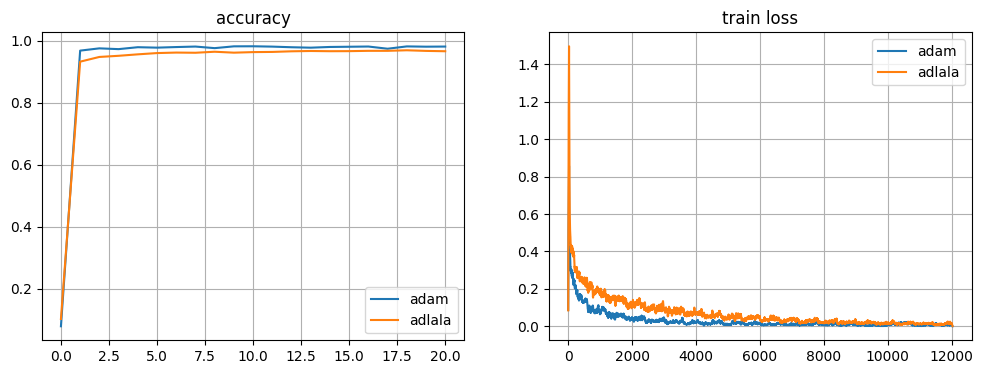

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(accuracy_history, label='adam')
axs[0].plot(accuracy_history_adlala, label='adlala')
axs[0].legend()
axs[0].grid()
axs[0].set_title('accuracy')
if False:
    # average loss per epoch
    loss_to_plot = epoch_train_loss
    loss_to_plot_adlala = epoch_train_loss_adlala
else:
    # sliding average of the loss per step
    loss_to_plot = np.convolve(train_loss, [1/27]*27)
    loss_to_plot_adlala = np.convolve(train_loss_adlala, [1/27]*27)
axs[1].plot(loss_to_plot, label='adam')
axs[1].plot(loss_to_plot_adlala, label='adlala')
axs[1].legend()
axs[1].grid()
axs[1].set_title('train loss')


In [ ]:
from PIL import Image
import pathlib

all_images = []

for path in pathlib.Path().glob('*.jpeg'):
    img = Image.open(path)

    img = img.resize((28, 28))
    img = np.array(img).astype(float)
    img = np.mean(img, axis=2)
    img /= 255.
    img = 1. - img
    all_images.append(img)

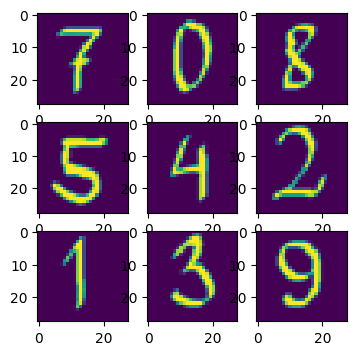

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(4, 4))
for i, el in enumerate(all_images):
    axs[i // 3, i % 3].imshow(el)

In [ ]:
all_images_numpy = np.array(all_images)
all_images_numpy = (all_images_numpy - 0.1307)/0.3081

In [ ]:
img_pytorch = torch.Tensor(all_images_numpy.reshape(-1, 28*28)).cuda()
res = net(img_pytorch)
print(res)

tensor([[ -3.1765,   4.0048,   8.7786,   6.7589,  -3.2700,  -2.7849,  -2.5900,
           5.9380,   7.5540, -13.9630],
        [ 16.5864,  -8.3430,  13.0349,  -2.1981,   7.1118, -12.6153,  -7.0280,
           2.7407,  -1.2379,   0.7734],
        [ -5.0401,  -8.5636,   2.3166,   0.4159,  -7.1733,  15.9332,   0.2087,
         -25.4562,  19.0113, -10.7534],
        [-18.1025, -10.8337,  -1.7802,  20.9303, -25.2841,  38.2007,  -3.0213,
         -21.0575,  13.8226,   3.7170],
        [-12.8354,  -8.4598, -12.4816, -10.2822,  19.7372,  -0.4109, -15.2141,
          -1.5550,  -2.0961,   9.5910],
        [  4.5988,  12.6045,  20.5743,  14.5000, -16.9833,   0.9924,  -3.5271,
           1.6492,   1.5134,  -8.8935],
        [ -8.3488,   6.3411,   0.6121,   4.9147,  -3.2648,  -4.2817,  -9.5035,
         -10.1406,   4.6502, -10.2649],
        [  0.1899,  16.7125,   2.6788,  29.0569, -17.8596,   8.9355,  -5.3890,
          -9.4980,  11.0041,   1.2366],
        [  9.5079,  -8.7082,  -1.1566,  11.4402,

In [ ]:
_, pred = torch.max(res, 1)
print(pred)

tensor([2, 0, 8, 5, 4, 2, 1, 3, 8], device='cuda:0')
